In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import h5py
import numpy as np
from keras.utils import np_utils
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
import tqdm
import os
import cv2

In [5]:
file = h5py.File('/content/drive/My Drive/dataset.hdf5',mode = 'r')

In [6]:
x_train = file['x_train'][:]
y_train = file['y_train'][:]
x_val = file['x_val'][:]
y_val = file['y_val'][:]
x_test = file['x_test'][:]
y_test = file['y_test'][:]

In [7]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_val /= 255
x_test /= 255

In [8]:
vgg = VGG19(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

80142336/80134624 [==============================] - 1s 0us/step


In [9]:
for layer in vgg.layers:
    layer.trainable = False

In [10]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

In [11]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("/content/drive/My Drive/weights_695.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=True)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [13]:
history = model.fit(x_train,y_train, batch_size = 64, epochs = 30, validation_data=(x_val,y_val),shuffle = True,verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/30
66/66 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.8722
Epoch 00001: val_accuracy improved from -inf to 0.93169, saving model to /content/drive/My Drive/weights_695.h5
66/66 [==============================] - 25s 385ms/step - loss: 0.2800 - accuracy: 0.8722 - val_loss: 0.1770 - val_accuracy: 0.9317
Epoch 2/30
66/66 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9533
Epoch 00002: val_accuracy improved from 0.93169 to 0.94118, saving model to /content/drive/My Drive/weights_695.h5
66/66 [==============================] - 23s 348ms/step - loss: 0.1288 - accuracy: 0.9533 - val_loss: 0.1530 - val_accuracy: 0.9412
Epoch 3/30
66/66 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9637
Epoch 00003: val_accuracy improved from 0.94118 to 0.94782, saving model to /content/drive/My Drive/weights_695.h5
66/66 [==============================] - 23s 354ms/step - loss: 0.1002 - accuracy: 0.9637 - val_loss: 0.1397 - v

In [14]:
model.evaluate(x_test,y_test)

19/19 [==============================] - 3s 181ms/step - loss: 0.1155 - accuracy: 0.9573


[0.11553595960140228, 0.9573378562927246]

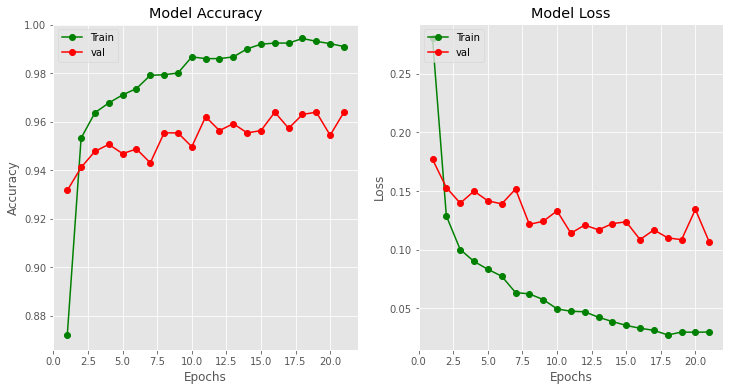

In [15]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,len(history.history['accuracy'])+1)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()